### imports

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import sys 
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

### get data

In [2]:
data = np.loadtxt(open('mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [3]:
# onvert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

### Create the DL model

In [4]:
class mnistNet(nn.Module):
    def __init__(self, nUnits, nLayers):
        super().__init__()

        # create dictionary to store the layers
        self.layers = nn.ModuleDict()
        self.nLayers = nLayers

        ### input layer
        self.layers["input"] = nn.Linear(784, nUnits)

        ### hidden layers
        for i in range(nLayers):
            self.layers[f"hidden{i}"] = nn.Linear(nUnits, nUnits)

        ### output layer
        self.layers["output"] = nn.Linear(nUnits, 10)

    # forward pass
    def forward(self, x):
        x = F.relu(self.layers["input"](x))

        for i in range(self.nLayers):
            x = F.relu(self.layers[f"hidden{i}"](x))

        x = self.layers["output"](x)
        return x


def createTheMNISTNet(nUnits, nLayers):
    net = mnistNet(nUnits, nLayers)
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    return net, lossfun, optimizer

In [5]:
# Generate an instance of the model and confirm that it returns the expected network.
nUnitsPerLayer = 12
nLayers = 4
net = createTheMNISTNet(nUnitsPerLayer,nLayers)
net

(mnistNet(
   (layers): ModuleDict(
     (input): Linear(in_features=784, out_features=12, bias=True)
     (hidden0): Linear(in_features=12, out_features=12, bias=True)
     (hidden1): Linear(in_features=12, out_features=12, bias=True)
     (hidden2): Linear(in_features=12, out_features=12, bias=True)
     (hidden3): Linear(in_features=12, out_features=12, bias=True)
     (output): Linear(in_features=12, out_features=10, bias=True)
   )
 ),
 CrossEntropyLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

### Create a function that trains the model

In [6]:
# a function that trains the model

def function2trainTheModel(nUnits,nLayers):

  # number of epochs
  numepochs = 50

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet(nUnits,nLayers)

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


### Run the model and show the results!

In [ ]:
numlayers = range(1,5)           # number of hidden layers
numunits  = np.arange(25,251,25) # units per hidden layer

accuracies  = np.zeros((2,len(numunits),len(numlayers)))

for unitidx in range(len(numunits)):
  for layeridx in range(len(numlayers)):

    # create and train a fresh model
    trainAcc,testAcc,losses,net = function2trainTheModel(numunits[unitidx],numlayers[layeridx])

    # store the results (average of final 5 epochs)
    accuracies[0,unitidx,layeridx] = np.mean(trainAcc[-5:])
    accuracies[1,unitidx,layeridx] = np.mean(testAcc[-5:])

    msg = f'Finished units {unitidx+1}/{len(numunits)} and layers {layeridx+1}/{len(numlayers)}'
    sys.stdout.write(msg + '\r')

# approx time: 1 hour

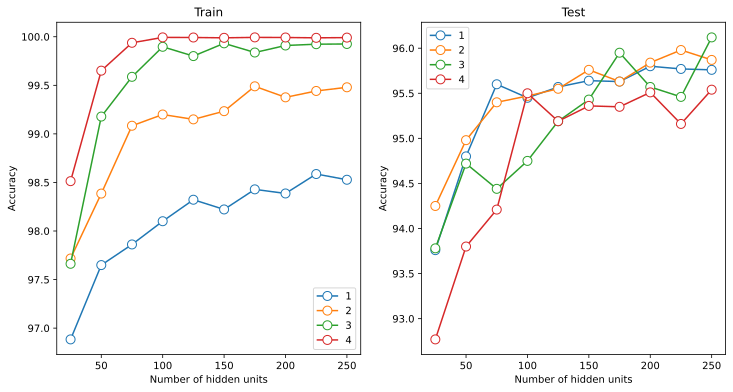

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,6))

ax[0].plot(numunits,accuracies[0,:,:],'o-',markerfacecolor='w',markersize=9)
ax[1].plot(numunits,accuracies[1,:,:],'o-',markerfacecolor='w',markersize=9)

for i in range(2):
  ax[i].legend(numlayers)
  ax[i].set_ylabel('Accuracy')
  ax[i].set_xlabel('Number of hidden units')
  ax[i].set_title([ 'Train' if i==0 else 'Test' ][0])

plt.show()

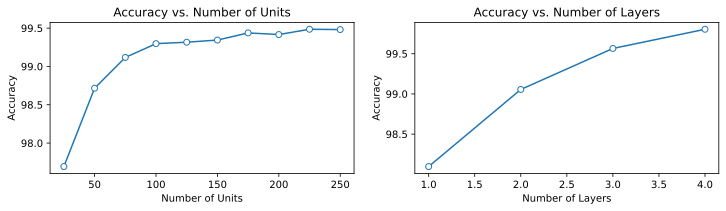

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(numunits, np.mean(accuracies[0], axis=1), "o-", markerfacecolor="w")
plt.title("Accuracy vs. Number of Units")
plt.xlabel("Number of Units")
plt.ylabel("Accuracy")

plt.subplot(2, 2, 2)
plt.plot(numlayers, np.mean(accuracies[0], axis=0), "o-", markerfacecolor="w")
plt.title("Accuracy vs. Number of Layers")
plt.xlabel("Number of Layers")
plt.ylabel("Accuracy")
plt.show()